In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from keras.layers import Dense, Flatten, Embedding, Multiply, Concatenate, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

def fix_all_seeds(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
fix_all_seeds(2021)

def fix_all_seeds(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
fix_all_seeds(2021)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##################################################################################
Start distribution mode: balanced
##################################################################################
single site training on UKA
acc 94.74, precision 98.25, recall 87.50, f1 92.56
single site training on UMG
acc 91.81, precision 96.30, recall 81.25, f1 88.14
single site training on UKK
acc 91.23, precision 94.55, recall 81.25, f1 87.39
single site training on UKL
acc 95.32, precision 100.00, recall 87.50, f1 93.33
single site training on IMISE
acc 93.57, precision 100.00, recall 82.81, f1 90.60
single site training on HSM
acc 92.40, precision 94.74, recall 84.38, f1 89.26
institutional incremental learning
test loss 0.19058650732040405 test_acc 0.935672514619883 test_prec 0.9649122807017544 test_rec 0.859375 test_f1 0.9090909090909091
cyclic institutional incremental learning
test loss 0.19309993088245392 test_acc 0.9239766081871345 test_prec 0.9636363636363636 test_rec 0.828125 test_f1 0

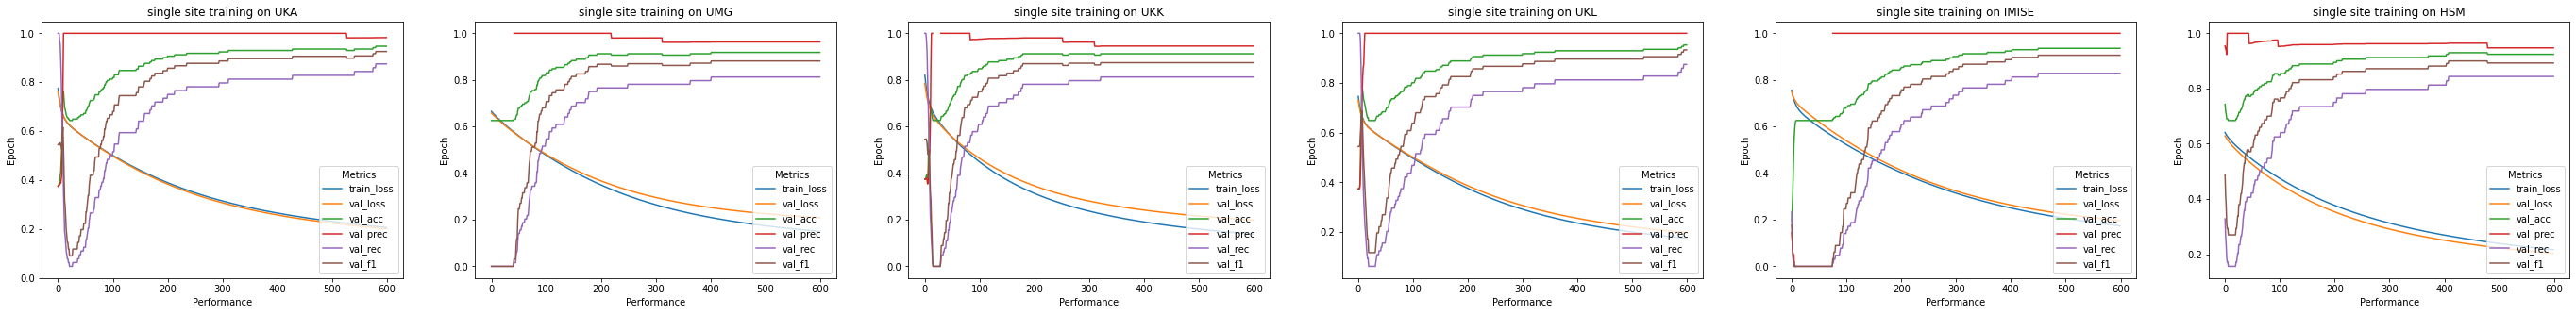

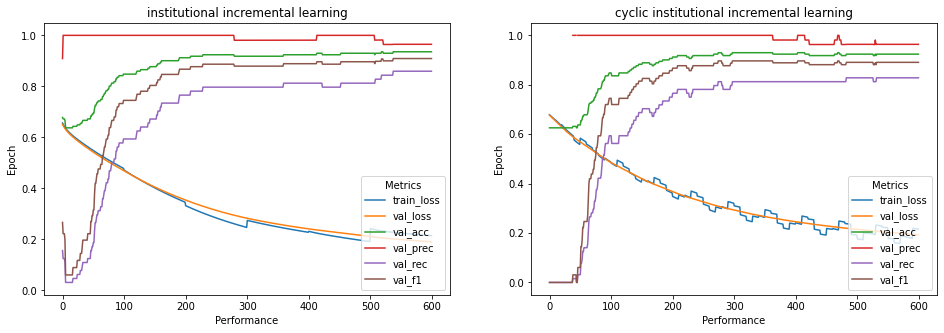

##################################################################################
Start distribution mode: unbalanced_label
##################################################################################
single site training on UKA
acc 92.98, precision 96.43, recall 84.38, f1 90.00
single site training on UMG
acc 91.23, precision 100.00, recall 76.56, f1 86.73
single site training on UKK
acc 92.98, precision 94.83, recall 85.94, f1 90.16
single site training on UKL
acc 92.98, precision 96.43, recall 84.38, f1 90.00
single site training on IMISE
acc 94.15, precision 89.71, recall 95.31, f1 92.42
single site training on HSM
acc 91.23, precision 100.00, recall 76.56, f1 86.73
institutional incremental learning
test loss 0.2135094702243805 test_acc 0.9181286549707602 test_prec 1.0 test_rec 0.78125 test_f1 0.8771929824561403
cyclic institutional incremental learning
test loss 0.20361372828483582 test_acc 0.9239766081871345 test_prec 0.9636363636363636 test_rec 0.828125 test_f1 0.8907563

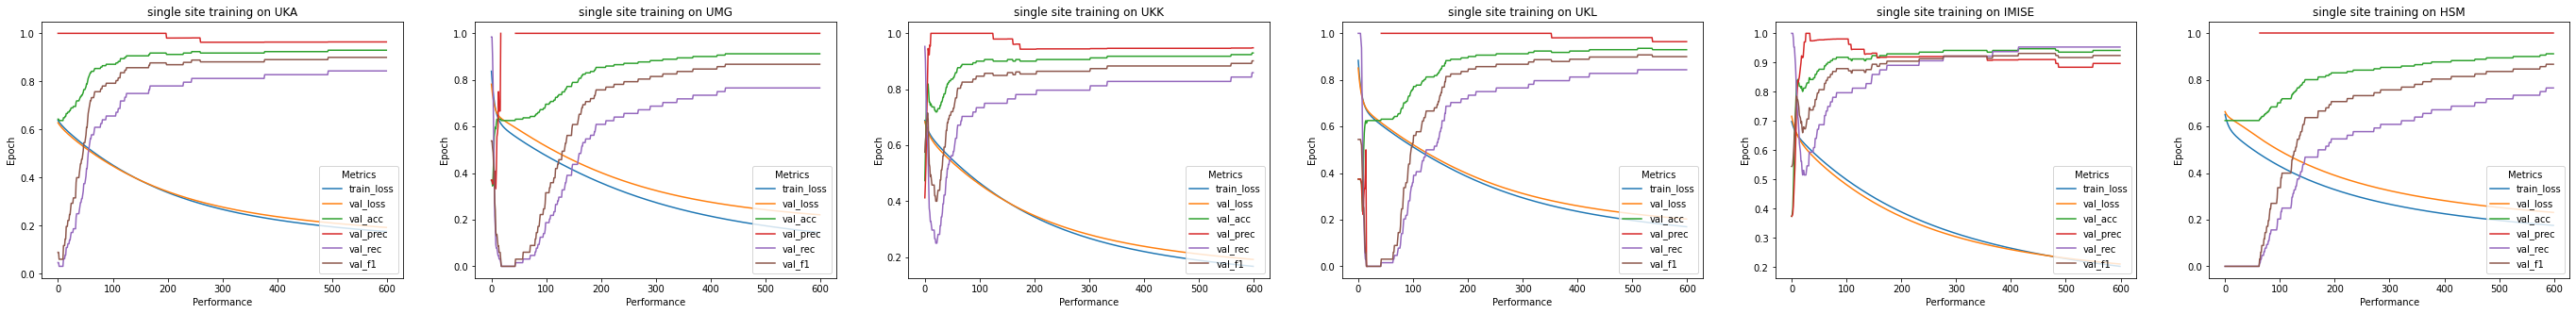

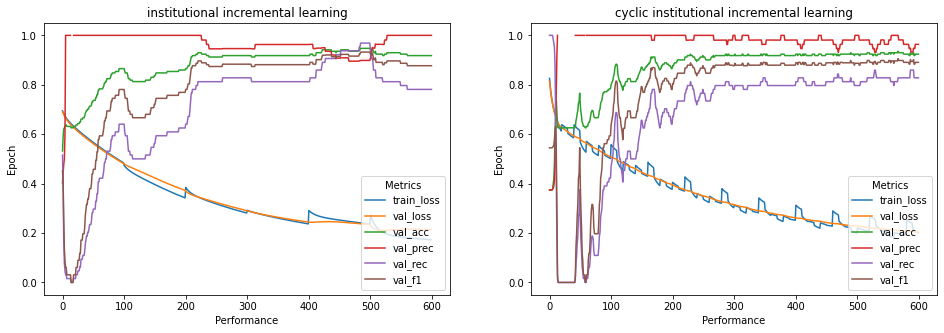

##################################################################################
Start distribution mode: unbalanced_labels_size
##################################################################################
single site training on UKA
acc 91.81, precision 94.64, recall 82.81, f1 88.33
single site training on UMG
acc 88.30, precision 100.00, recall 68.75, f1 81.48
single site training on UKK
acc 92.40, precision 96.36, recall 82.81, f1 89.08
single site training on UKL
acc 94.15, precision 93.55, recall 90.62, f1 92.06
single site training on IMISE
acc 94.15, precision 96.55, recall 87.50, f1 91.80
single site training on HSM
acc 92.40, precision 93.22, recall 85.94, f1 89.43
institutional incremental learning
test loss 0.2036140412092209 test_acc 0.9298245614035088 test_prec 0.9333333333333333 test_rec 0.875 test_f1 0.9032258064516129
cyclic institutional incremental learning
test loss 0.1922108232975006 test_acc 0.9415204678362573 test_prec 0.95 test_rec 0.890625 test_f1 0.9193

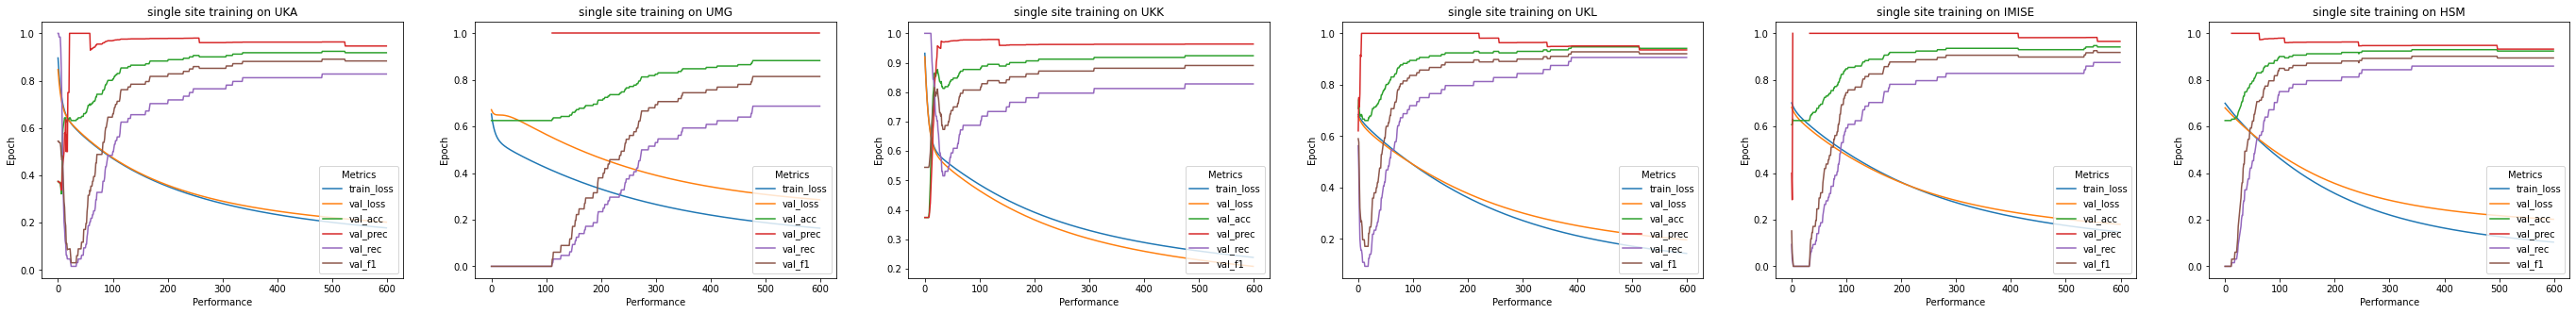

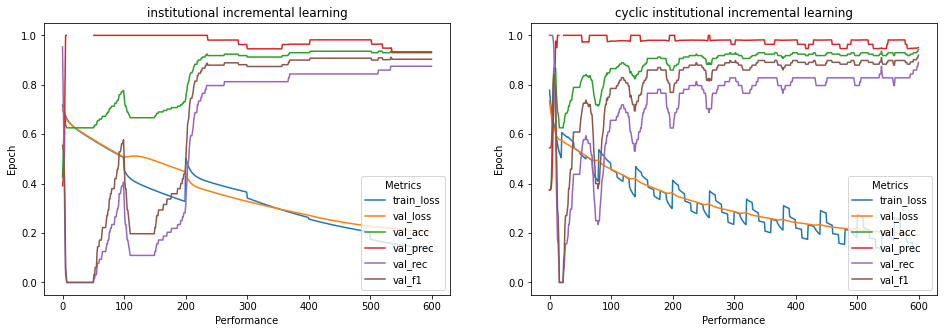

In [4]:
## distribution mode: "input_balanced", "unbalanced_label", "unbalanced_labels_size"
DISTRIBUTION_MODES = ["balanced", "unbalanced_label", "unbalanced_labels_size"]
X_FEATURES = ['radius_mean', 'texture_mean', 'perimeter_mean',
              'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
              'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
              'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
              'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
              'fractal_dimension_se', 'radius_worst', 'texture_worst',
              'perimeter_worst', 'area_worst', 'smoothness_worst',
              'compactness_worst', 'concavity_worst', 'concave points_worst',
              'symmetry_worst', 'fractal_dimension_worst']
## y feature name
Y_FEATURE = 'diagnosis'
BASE_DIR = "/content/drive/MyDrive/DSM-AS"
DATA_DIR = osp.join(BASE_DIR, "input")
RESULT_DIR = osp.join(BASE_DIR, "output")

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.output_layer = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out = self.output_layer(self.sigmoid(self.hidden_layer(x)))
        return out

def train(X_train, y_train, model, criterion, optimizer):
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).long()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.item()

def valid(X_test, y_test, model, criterion):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).long()
    outputs = model(inputs)
    val_loss = criterion(outputs, targets)
    _, predicted = torch.max(outputs, 1)
    cm = confusion_matrix(targets.numpy(), predicted.numpy())
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    with np.errstate(divide='ignore', invalid='ignore'):
        val_acc = (tp + tn) / (tp + fp + fn + tn)
        val_precesion = tp / (tp + fp)
        val_recall = tp / (tp + fn)
        val_f1_score = 2 * tp / (2 * tp + fn + fp)
    return val_loss.item(), val_acc, val_precesion, val_recall, val_f1_score

# df_mean_Xs = {}
# df_std_Xs = {}
# df_counts = {}
# df_performances = {}
for distribution_mode in DISTRIBUTION_MODES:
    print("##################################################################################")
    print("Start distribution mode: {}".format(distribution_mode))
    print("##################################################################################")
    experiment_dir = osp.join(RESULT_DIR,"R",distribution_mode)
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)
    df_data = pd.read_csv(osp.join(DATA_DIR, "data.csv"))
    df_data = df_data.drop(["Unnamed: 32"], axis=1)
    station_list = ["uka", "umg", "ukk", "ukl", "imise", "hsm"]
    station_dfs = [pd.read_csv(osp.join(DATA_DIR, "{}/{}.csv".format(distribution_mode, station))).rename(columns={"patient_id":"id"}) for station in station_list]
    final_test_df = pd.read_csv(osp.join(DATA_DIR, "{}/final_test.csv".format(distribution_mode))).rename(columns={"patient_id":"id"})
    for idx in range(len(station_list)):
        station_dfs[idx]["id"] = station_dfs[idx]["id"].map(lambda x: int(x[6:]))
        station_dfs[idx] = pd.merge(df_data, station_dfs[idx], on='id', how='right')
    final_test_df["id"] = final_test_df["id"].map(lambda x: int(x[6:]))
    final_test_df = pd.merge(df_data, final_test_df, on='id', how='right')
    # df_count = []
    # for idx in range(len(station_dfs)):
    #     B, M = station_dfs[idx]["diagnosis"].value_counts()
    #     df_count.append([len(station_dfs[idx]), B, M])
    # B, M = final_test_df["diagnosis"].value_counts()
    # df_count.append([len(final_test_df), B, M])
    # df_count = pd.DataFrame(df_count, columns=["counts", "B", "M"])
    # df_count["station"] = pd.Series(station_list+["final test"])
    # df_mean_X = []
    # df_std_X = []
    # for idx in range(len(station_list)):
    #     df_mean_X.append(np.mean(station_dfs[idx][X_FEATURES], axis=0).to_numpy())
    #     df_std_X.append(np.std(station_dfs[idx][X_FEATURES], axis=0).to_numpy())
    # df_mean_X.append(np.mean(final_test_df[X_FEATURES], axis=0).to_numpy())
    # df_std_X.append(np.std(final_test_df[X_FEATURES], axis=0).to_numpy())
    # df_mean_X = pd.DataFrame(df_mean_X, columns=X_FEATURES)
    # df_std_X = pd.DataFrame(df_std_X, columns=X_FEATURES)
    # df_mean_X["station"] = pd.Series(station_list+["final test"])
    # df_std_X["station"] = pd.Series(station_list+["final test"])
    # df_counts[distribution_mode] = df_count
    # df_mean_Xs[distribution_mode] = df_mean_X
    # df_std_Xs[distribution_mode] = df_std_X

    test_scaler = StandardScaler()
    X_test = final_test_df[X_FEATURES]
    y_test = final_test_df[Y_FEATURE]
    X_test = test_scaler.fit_transform(X_test)
    y_test.replace(to_replace=dict(M=1, B=0), inplace=True)
    y_test = y_test.to_numpy()

    ##################################################################################
    ## Single site training
    ##################################################################################
    fig, axs = plt.subplots(1, 6,figsize=(48, 5))
    input_dim = 30
    hidden_dim = 64
    num_classes = 2
    learning_rate = 0.01
    weight_decay = 0.0005
    num_epochs = 600
    criterion = nn.CrossEntropyLoss()
    for idx in range(len(station_list)):
        scaler = StandardScaler()
        df_X = station_dfs[idx][X_FEATURES]
        df_Y = station_dfs[idx][Y_FEATURE]
        df_X = scaler.fit_transform(df_X)
        df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
        df_Y = df_Y.to_numpy()
        model = LogisticRegression(input_dim, hidden_dim, num_classes)
        optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        losses = []
        val_losses = []
        val_accs = []
        val_precs = []
        val_recs = []
        val_f1s = []
        results = []
        for epoch in range(num_epochs):
            perm = np.arange(df_X.shape[0])
            np.random.shuffle(perm)
            X_train = df_X[perm]
            y_train = df_Y[perm]
            loss = train(X_train, y_train, model, criterion, optim)
            val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_test, y_test, model, criterion)
            losses.append(loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_precs.append(val_precesion)
            val_recs.append(val_recall)
            val_f1s.append(val_f1_score)
            results.append([epoch, loss, val_loss, val_acc, val_precesion, val_recall, val_f1_score])
        axs[idx].plot(losses, label="train_loss")
        axs[idx].plot(val_losses, label="val_loss")
        axs[idx].plot(val_accs, label="val_acc")
        axs[idx].plot(val_precs, label="val_prec")
        axs[idx].plot(val_recs, label="val_rec")
        axs[idx].plot(val_f1s, label="val_f1")
        axs[idx].legend(title="Metrics", loc="lower right")
        axs[idx].title.set_text("single site training on {}".format(station_list[idx].upper())),
        axs[idx].set_ylabel("Epoch")
        axs[idx].set_xlabel("Performance")
        print("single site training on {}".format(station_list[idx].upper()))
        print("acc {:.2f}, precision {:.2f}, recall {:.2f}, f1 {:.2f}".format(val_accs[-1]*100, val_precs[-1]*100, val_recs[-1]*100, val_f1s[-1]*100))
        results = pd.DataFrame(np.array(results), columns=["epoch", "loss", "val_loss", "val_acc", "val_prec", "val_rec", "val_f1"])
        results.to_csv(osp.join(experiment_dir, f"sst_{station_list[idx]}_result.csv"),index=False)
          
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    ##################################################################################
    ## Institutional Incremental Learning
    ##################################################################################
    input_dim = 30
    hidden_dim = 64
    num_classes = 2
    learning_rate = 0.01
    weight_decay = 0.0005
    num_epochs = 100
    criterion = nn.CrossEntropyLoss()
    model = LogisticRegression(input_dim, hidden_dim, num_classes)
    losses = []
    val_losses = []
    val_accs = []
    val_precs = []
    val_recs = []
    val_f1s = []
    results = []
    for idx in range(len(station_list)):
        optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scaler = StandardScaler()
        df_X = station_dfs[idx][X_FEATURES]
        df_Y = station_dfs[idx][Y_FEATURE]
        df_X = scaler.fit_transform(df_X)
        # df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
        df_Y = df_Y.to_numpy()
        for epoch in range(num_epochs):
            perm = np.arange(df_X.shape[0])
            np.random.shuffle(perm)
            X_train = df_X[perm]
            y_train = df_Y[perm]
            loss = train(X_train, y_train, model, criterion, optim)
            val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_test, y_test, model, criterion)
            losses.append(loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_precs.append(val_precesion)
            val_recs.append(val_recall)
            val_f1s.append(val_f1_score)
            results.append([epoch, loss, val_loss, val_acc, val_precesion, val_recall, val_f1_score])
    axs[0].plot(losses, label="train_loss")
    axs[0].plot(val_losses, label="val_loss")
    axs[0].plot(val_accs, label="val_acc")
    axs[0].plot(val_precs, label="val_prec") 
    axs[0].plot(val_recs, label="val_rec")
    axs[0].plot(val_f1s, label="val_f1")
    axs[0].legend(title="Metrics", loc="lower right")
    axs[0].title.set_text("institutional incremental learning"),
    axs[0].set_ylabel("Epoch")
    axs[0].set_xlabel("Performance")
    print("institutional incremental learning")
    print("test loss", val_losses[-1], "test_acc", val_accs[-1], "test_prec", val_precs[-1], "test_rec", val_recs[-1], "test_f1", val_f1s[-1])
    results = pd.DataFrame(np.array(results), columns=["epoch", "loss", "val_loss", "val_acc", "val_prec", "val_rec", "val_f1"])
    results.to_csv(osp.join(experiment_dir, "iil_result.csv"),index=False) 
    
    ##################################################################################
    ## Cyclic Institutional Incremental Learning
    ##################################################################################
    input_dim = 30
    hidden_dim = 64
    num_classes = 2
    learning_rate = 0.01
    weight_decay = 0.0005
    num_cycles = 10
    num_epochs = 10
    criterion = nn.CrossEntropyLoss()
    model = LogisticRegression(input_dim, hidden_dim, num_classes)
    losses = []
    val_losses = []
    val_accs = []
    val_precs = []
    val_recs = []
    val_f1s = []
    results = []
    for cycle in range(num_cycles):
        for idx in range(len(station_list)):
            optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scaler = StandardScaler()
            df_X = station_dfs[idx][X_FEATURES]
            df_Y = station_dfs[idx][Y_FEATURE]
            df_X = scaler.fit_transform(df_X)
            # df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
            df_Y = df_Y.to_numpy()
            for epoch in range(num_epochs):
                perm = np.arange(df_X.shape[0])
                np.random.shuffle(perm)
                X_train = df_X[perm]
                y_train = df_Y[perm]
                loss = train(X_train, y_train, model, criterion, optim)
                val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_test, y_test, model, criterion)
                losses.append(loss)
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_precs.append(val_precesion)
                val_recs.append(val_recall)
                val_f1s.append(val_f1_score)
                results.append([epoch, loss, val_loss, val_acc, val_precesion, val_recall, val_f1_score])

    axs[1].plot(losses, label="train_loss")
    axs[1].plot(val_losses, label="val_loss")
    axs[1].plot(val_accs, label="val_acc")
    axs[1].plot(val_precs, label="val_prec") 
    axs[1].plot(val_recs, label="val_rec")
    axs[1].plot(val_f1s, label="val_f1")
    axs[1].legend(title="Metrics", loc="lower right")
    axs[1].title.set_text("cyclic institutional incremental learning"),
    axs[1].set_ylabel("Epoch")
    axs[1].set_xlabel("Performance")
    print("cyclic institutional incremental learning")
    print("test loss", val_losses[-1], "test_acc", val_accs[-1], "test_prec", val_precs[-1], "test_rec", val_recs[-1], "test_f1", val_f1s[-1])
    results = pd.DataFrame(np.array(results), columns=["epoch", "loss", "val_loss", "val_acc", "val_prec", "val_rec", "val_f1"])
    results.to_csv(osp.join(experiment_dir, "ciil_result.csv"),index=False)     
    plt.show()